# About the Dataset

## What is a brain tumor?

A brain tumor is a collection, or mass, of abnormal cells in the brain. The skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or non-cancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside the skull to increase. This can cause brain damage, and it can be life-threatening.

## The importance of the subject

Early detection and classification of brain tumors is an important research domain in the field of medical imaging and accordingly helps in selecting the most convenient treatment method to save patients' life.

## Methods

The application of deep learning (DL) approaches in context to improve health diagnosis is providing impactful solutions. According to the World Health Organization (WHO), proper brain tumor diagnosis involves detection, brain tumor location identification, and classification of the tumor on the basis of malignancy, grade, and type. 


This experimental work in the diagnosis of brain tumors using Magnetic Resonance Imaging (MRI) involves detecting the tumor, classifying the tumor in terms of grade, type, and identification of tumor location. This method has experimented in terms of utilizing one model for classifying brain MRI on different classification tasks rather than an individual model for each classification task. The <b>Convolutional Neural Network (CNN)</b> and <b>Computer Vision</b> based multi-task classification is equipped for the classification and detection of tumors. The identification of brain tumor location is also done using a CNN-based model by segmenting the brain tumor.

## Dataset Link

https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

# Developing the Brain Tumor Detection Model

## Importing the necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis for the Brain Tumor MRI Dataset

### For Training Data

In [2]:
Train_df = 'Brain Tumor MRI Dataset/Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████████████████████████████████████████████████████████████████████| 1457/1457 [00:00<00:00, 348906.70it/s]


In [3]:
print(len(filepaths))
print(len(labels))

5712
5712


In [4]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [5]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [6]:
df_train.head()

,filepath,label
0,Brain Tumor MRI Dataset/Training\glioma\Tr-glT...,glioma
1,Brain Tumor MRI Dataset/Training\glioma\Tr-glT...,glioma
2,Brain Tumor MRI Dataset/Training\glioma\Tr-glT...,glioma
3,Brain Tumor MRI Dataset/Training\glioma\Tr-glT...,glioma
4,Brain Tumor MRI Dataset/Training\glioma\Tr-glT...,glioma


In [7]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']

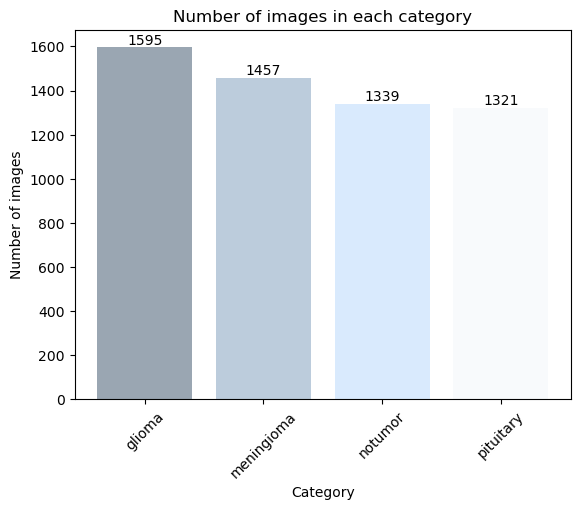

In [8]:
fig, ax = plt.subplots()
bars = ax.bar(df_train['label'].unique(), df_train['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

### For Tesing Data

In [9]:
Test_df = 'Brain Tumor MRI Dataset/Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<?, ?it/s]


In [10]:
print(len(filepaths))
print(len(labels))

1311
1311


In [11]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [12]:
df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [13]:
df_test.head()

,filepath,label
0,Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...,glioma
1,Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...,glioma
2,Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...,glioma
3,Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...,glioma
4,Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...,glioma


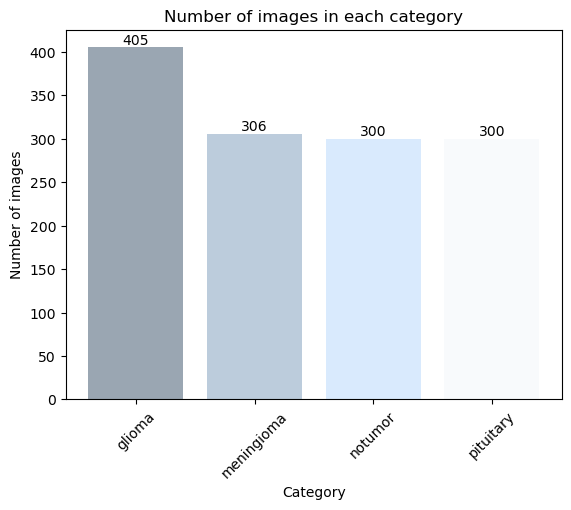

In [14]:
fig, ax = plt.subplots()
bars = ax.bar(df_test['label'].unique(), df_test['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

## Loading Data for Model Development

In [15]:
# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
# Setting Directories
train_dir = 'Brain Tumor MRI Dataset/Training'
test_dir = 'Brain Tumor MRI Dataset/Testing'

In [17]:
# Image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

In [18]:
# Preprocessing grayscale to 3 (RGB) channels
def preprocess_image(image):
    if len(image.shape) == 2:  # Grayscale image
        image = np.stack((image,) * 3, axis=-1)  # Duplicate channels
    return image

In [19]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2])

In [20]:
# Data augmentation
test_datagen = ImageDataGenerator(
    rescale=1.0/255
)

In [21]:
train_datagen.preprocessing_function = preprocess_image
test_datagen.preprocessing_function = preprocess_image

In [22]:
# Loading Images and Applying Preprocessing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [23]:
# Displaying Class Imbalance
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
print(f"Class Distribution: {np.bincount(class_counts)}")

# Computing Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_counts),
    y=class_counts
)
class_weights = dict(enumerate(class_weights))
print(f"Computed Class Weights: {class_weights}")

Class Distribution: [1321 1339 1595 1457]
Computed Class Weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


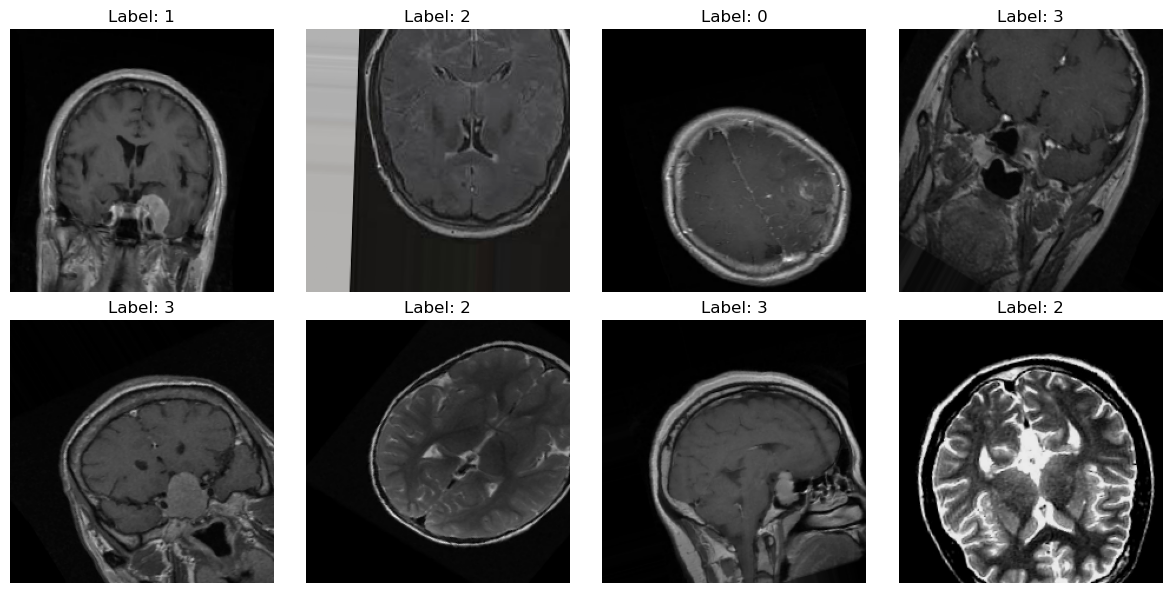

In [24]:
# Visualizing Some Augmented Images
def visualize_augmented_images(generator, num_images=8):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Label: {np.argmax(y_batch[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_augmented_images(train_generator)

## Developing the Deep Learning Model

In [25]:
# Creating VGG16 Model with Fine-Tuning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freezing the initial layers (first 15 layers)
for layer in base_model.layers[:15]:
    layer.trainable = False

# Unfreezing the last few layers for fine-tuning (from layer 15 onwards)
for layer in base_model.layers[15:]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [26]:
# Defining Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')
])

In [27]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)

In [29]:
model_checkpoint = ModelCheckpoint('Brain Tumor Detection Best Model.keras', monitor='val_loss', save_best_only=True)

In [30]:
# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 1196s 7s/step - accuracy: 0.6153 - loss: 0.8782 - val_accuracy: 0.8516 - val_loss: 0.4341 - learning_rate: 1.0000e-04
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.8750 - loss: 0.3000 - val_accuracy: 0.8469 - val_loss: 0.4518 - learning_rate: 1.0000e-04
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 1275s 7s/step - accuracy: 0.8709 - loss: 0.3508 - val_accuracy: 0.8516 - val_loss: 0.4079 - learning_rate: 1.0000e-04
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9062 - loss: 0.4079 - val_accuracy: 0.8305 - val_loss: 0.4687 - learning_rate: 1.0000e-04
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 1312s 7s/step - accuracy: 0.8938 - loss: 0.3092 - val_accuracy: 0.8891 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9375 - loss: 0.2399 - val_accuracy: 0.8938 - val_loss: 0.3278 - learning_rate: 1.0000e-04
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 1265s 7s/step -

## Testing and Evaluating

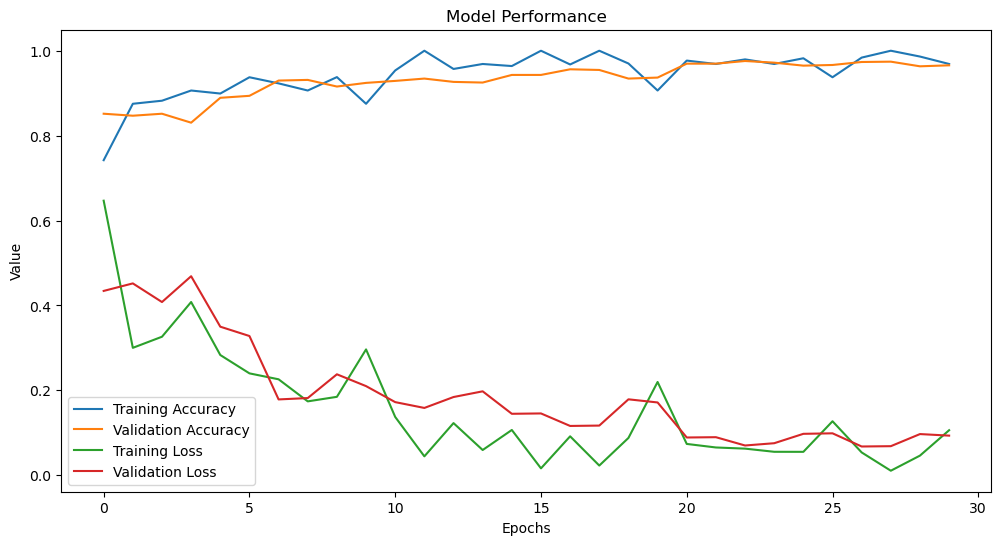

In [31]:
# Visualizing Training Results
def plot_results(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_results(history)

In [32]:
# Evaluating Model
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
accuracy = np.mean(y_pred_classes == y_true)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.2f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step
Accuracy: 97.41%
Validation Accuracy: 0.97


In [33]:
model.save('Brain Tumor Detection Model.keras')

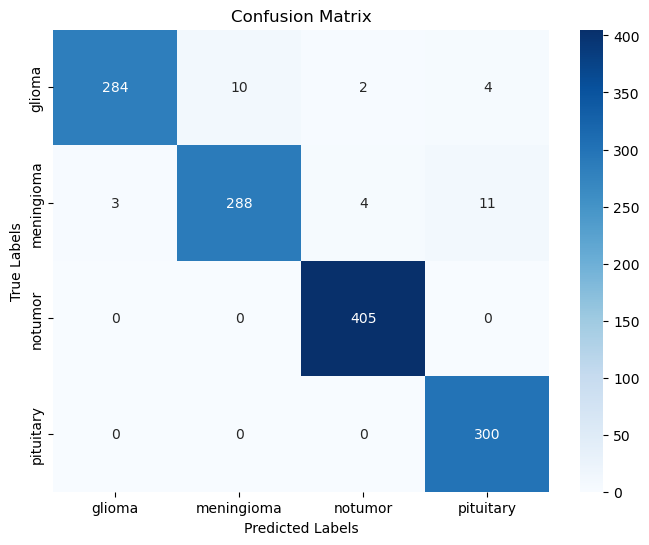

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.97      0.94      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.95      1.00      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



## Predicting for a New Brain MRI Scan

In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_path = "Brain Tumor MRI Dataset/Testing/pituitary/Te-pi_0029.jpg"
img = load_img(image_path, target_size=(img_width, img_height))

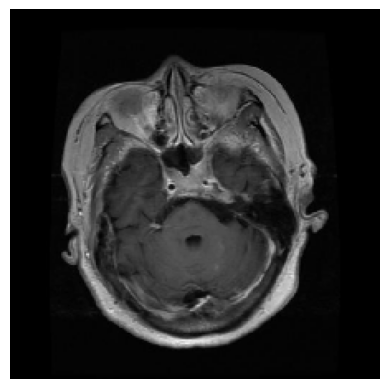

In [37]:
# Displaying the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [40]:
# Preprocessing Image
img_array = img_to_array(img)
img_array = preprocess_image(img_array)
img_array = np.expand_dims(img_array / 255.0, axis=0)

# Making Prediction
predictions = model.predict(img_array)
class_index = np.argmax(predictions)
confidence = predictions[0][class_index]

# Class labels and final result
predicted_label = class_labels[class_index]
print(f"Predicted Tumor Class: {predicted_label}, Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Predicted Tumor Class: pituitary, Confidence: 0.98
